# Tree Models

This notebooks contains my exploration of tree-based models including decision trees, random forest models, gradient boosting machines, and Bayesian Additive Regression Trees.  The product of this notebook will be a model that can be used for prediction.

------

## Contents<a id='Contents'></a>
* [XXXX](#introduction--feature-descriptions)
* [Imports & Reading Data](#imports--readingpreparing-data)
---

## Imports & Reading Data

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/Concrete_Data_Yeh.csv')
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('csMPa', axis = 1)
y = df['csMPa']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

## Single Decision Tree Regressor

In [5]:
single_tree = DecisionTreeRegressor(random_state=0)
params = {'max_depth': range(2, 25, 2)}

grid_cv = GridSearchCV(estimator=single_tree, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv.fit(X_train, y_train)

grid_cv_results=pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results.head(9)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.007580,0.001197,0.001995,6.308264e-04,20,{'max_depth': 20},-40.531614,-42.414395,-45.389630,-33.571423,-54.704880,-43.322388,6.892442,1
10,0.007780,0.000747,0.002393,4.885002e-04,22,{'max_depth': 22},-40.531614,-42.414395,-45.389630,-33.571423,-54.704880,-43.322388,6.892442,1
11,0.007979,0.001262,0.001994,3.234067e-07,24,{'max_depth': 24},-40.531614,-42.414395,-45.389630,-33.571423,-54.704880,-43.322388,6.892442,1
8,0.007380,0.000489,0.001995,1.507891e-07,18,{'max_depth': 18},-41.676816,-42.414395,-45.389630,-33.571423,-54.704880,-43.551429,6.814484,4
5,0.007978,0.000892,0.002393,4.887530e-04,12,{'max_depth': 12},-42.951701,-43.056131,-51.460341,-33.989974,-51.485795,-44.588788,6.513845,5
7,0.007380,0.000798,0.001995,2.861023e-07,16,{'max_depth': 16},-39.551544,-45.109843,-44.177594,-39.197910,-56.444837,-44.896346,6.244500,6
6,0.008377,0.001353,0.002593,7.978559e-04,14,{'max_depth': 14},-41.418477,-43.169334,-53.133270,-37.780441,-56.730160,-46.446337,7.233090,7
4,0.008578,0.002411,0.003191,1.466142e-03,10,{'max_depth': 10},-44.302784,-45.425373,-53.352532,-39.152004,-52.263059,-46.899150,5.279187,8
3,0.006781,0.000747,0.002793,7.464676e-04,8,{'max_depth': 8},-52.226818,-56.209535,-54.326532,-42.088108,-52.992747,-51.568748,4.929212,9


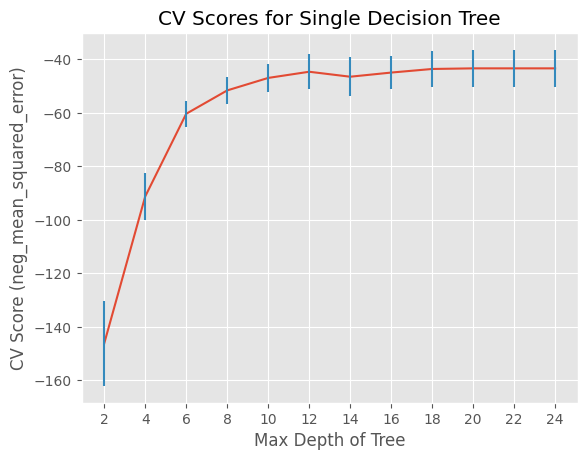

In [6]:
tree_cv_score = sns.lineplot(data = grid_cv_results, x = 'param_max_depth', y = 'mean_test_score')
tree_cv_score.set_xticks(params['max_depth'])
plt.errorbar(data = grid_cv_results, x='param_max_depth', y='mean_test_score', yerr='std_test_score', linestyle='')
plt.title('CV Scores for Single Decision Tree')
plt.ylabel('CV Score (neg_mean_squared_error)')
plt.xlabel('Max Depth of Tree')
plt.show()

In [7]:
best_tree = DecisionTreeRegressor(max_depth=20, random_state=0)
best_tree.fit(X_train, y_train)

y_test_pred = best_tree.predict(X_test)
single_tree_test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Single Tree Train CV Score (MSE): {-1*cross_val_score(best_tree, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error").mean():.3f}')
print(f'Single Tree Test MSE: {single_tree_test_mse:.3f}')

Single Tree Train CV Score (MSE): 43.322
Single Tree Test MSE: 45.856


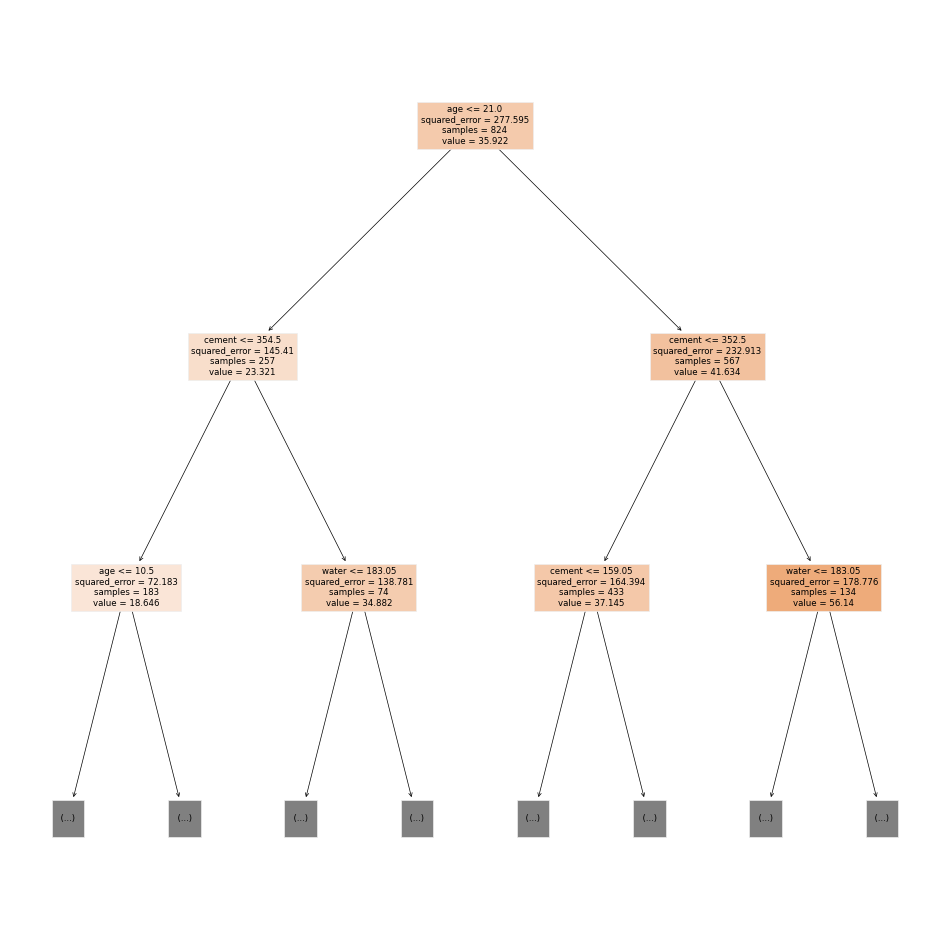

In [8]:
plt.figure(figsize=(12,12))
features = df.columns
plot_tree(best_tree, feature_names=features, filled=True, max_depth=2)
plt.show()

### Cost Complexity Pruning

In [9]:
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [10]:
trees = []

for alpha in ccp_alphas:
    subtree = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    subtree.fit(X_train, y_train)
    trees.append(subtree)

In [11]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [subtree.tree_.node_count for subtree in trees]
depth = [subtree.tree_.max_depth for subtree in trees]

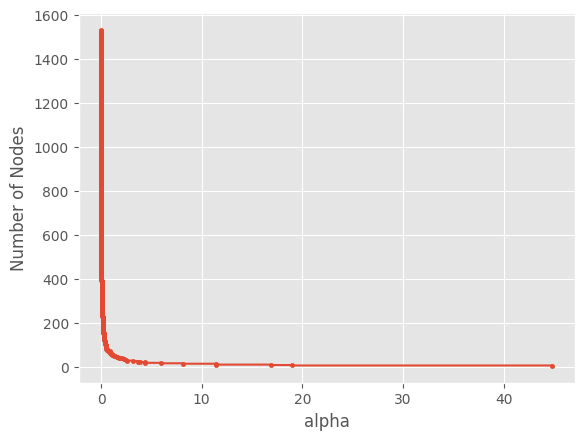

In [12]:
plt.scatter(ccp_alphas, node_counts, marker='.')
plt.plot(ccp_alphas, node_counts, drawstyle="steps-post")
plt.ylabel('Number of Nodes')
plt.xlabel('alpha')
plt.show()

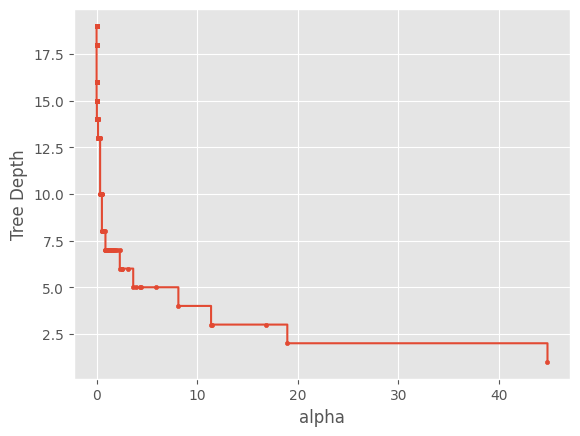

In [13]:
plt.scatter(ccp_alphas, depth, marker='.')
plt.plot(ccp_alphas, depth, drawstyle="steps-post")
plt.ylabel('Tree Depth')
plt.xlabel('alpha')
plt.show()

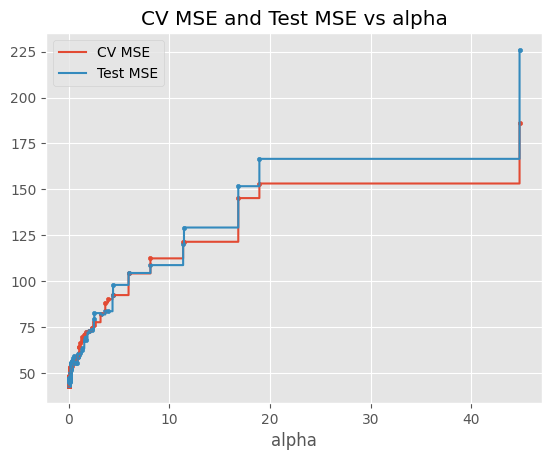

In [14]:
cv_mse = []
test_mse = []

for subtree in trees:
    cv_mse.append(-1*cross_val_score(subtree, X_train, y_train, scoring='neg_mean_squared_error', cv = 5).mean())
    y_test_pred = subtree.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_test_pred))

plt.scatter(ccp_alphas, cv_mse, marker='.')
plt.scatter(ccp_alphas, test_mse, marker='.')
plt.plot(ccp_alphas, cv_mse, label='CV MSE', drawstyle="steps-post")
plt.plot(ccp_alphas, test_mse, label='Test MSE', drawstyle="steps-post")
plt.xlabel('alpha')
plt.legend()
plt.title('CV MSE and Test MSE vs alpha')
plt.show()

## Random Forest Model

In [15]:
forest = RandomForestRegressor(random_state=0, oob_score=True)
params = {'n_estimators': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150],
          'min_samples_split': [2, 5, 10, 25, 50, 100],
          'max_features': [1, 2, 3, 4, 5]}

grid_cv_tree = GridSearchCV(estimator=forest, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10, 25, 50, 100],
                         'n_estimators': [1, 5, 10, 20, 30, 40, 50, 75, 100,
                                          125, 150]},
             scoring='neg_mean_squared_error')

In [16]:
grid_cv_results_tree=pd.DataFrame(grid_cv_tree.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_tree.head(9)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
274,0.958238,0.030128,0.023338,0.001017,5,2,150,"{'max_features': 5, 'min_samples_split': 2, 'n...",-28.332793,-31.541106,-32.894989,-19.701645,-27.180203,-27.930147,4.606983,1
208,0.856709,0.025699,0.024135,0.003420,4,2,150,"{'max_features': 4, 'min_samples_split': 2, 'n...",-29.020643,-30.898157,-32.736415,-19.619368,-27.545138,-27.963944,4.523495,2
273,0.795672,0.024805,0.018949,0.000630,5,2,125,"{'max_features': 5, 'min_samples_split': 2, 'n...",-27.916769,-31.823475,-33.149825,-19.881645,-27.218022,-27.997947,4.640382,3
272,0.657641,0.013225,0.017354,0.001850,5,2,100,"{'max_features': 5, 'min_samples_split': 2, 'n...",-27.813719,-31.473197,-34.229109,-20.105240,-27.581410,-28.240535,4.756317,4
207,0.728253,0.028839,0.021343,0.002998,4,2,125,"{'max_features': 4, 'min_samples_split': 2, 'n...",-29.471061,-31.296553,-32.907434,-19.779558,-27.903710,-28.271663,4.567935,5
271,0.471141,0.008843,0.012565,0.000489,5,2,75,"{'max_features': 5, 'min_samples_split': 2, 'n...",-28.279784,-31.730128,-34.032598,-20.256100,-27.448318,-28.349386,4.691404,6
206,0.594211,0.027447,0.016955,0.001669,4,2,100,"{'max_features': 4, 'min_samples_split': 2, 'n...",-29.774570,-31.322788,-33.297493,-20.142897,-28.049993,-28.517548,4.531021,7
284,0.659836,0.010065,0.019747,0.001934,5,5,125,"{'max_features': 5, 'min_samples_split': 5, 'n...",-28.453174,-32.087568,-34.139299,-20.432918,-28.451712,-28.712934,4.680341,8
283,0.547336,0.019537,0.015957,0.000631,5,5,100,"{'max_features': 5, 'min_samples_split': 5, 'n...",-28.455835,-32.185061,-34.114784,-20.529966,-28.547063,-28.766542,4.653512,9


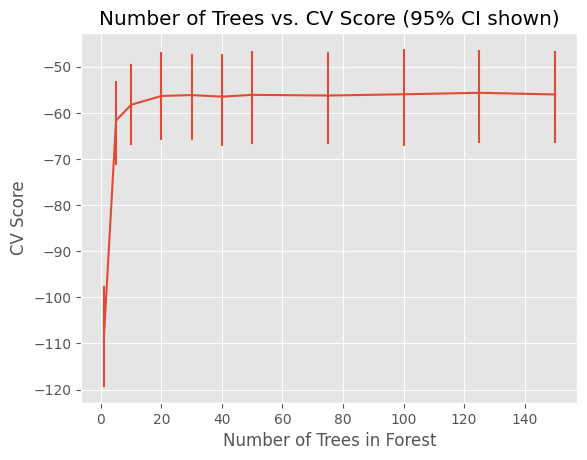

In [17]:
sns.lineplot(data=grid_cv_results_tree, x='param_n_estimators', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Number of Trees in Forest')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()

As the number of trees in the random forest increases, the CV score increases as well but levels off.  It seems that 20 trees is sufficient to obtain an accurate model. 

In [18]:
forest_20_trees = grid_cv_results_tree[grid_cv_results_tree['param_n_estimators'] == 20]
forest_20_trees.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
267,0.124068,0.002149,0.005385,7.977963e-04,5,2,20,"{'max_features': 5, 'min_samples_split': 2, 'n...",-28.377911,-33.039486,-36.559424,-21.079199,-30.064305,-29.824065,5.183160,30
278,0.118483,0.009841,0.004986,3.814697e-07,5,5,20,"{'max_features': 5, 'min_samples_split': 5, 'n...",-28.440712,-35.327867,-35.618570,-21.829161,-29.773075,-30.197877,5.079453,35
135,0.109308,0.009154,0.007181,4.388165e-03,3,2,20,"{'max_features': 3, 'min_samples_split': 2, 'n...",-29.519300,-33.890058,-38.101015,-20.854559,-30.974117,-30.667810,5.715736,41
212,0.097339,0.001620,0.004787,7.466970e-04,4,5,20,"{'max_features': 4, 'min_samples_split': 5, 'n...",-32.946729,-30.955106,-38.619259,-20.680681,-30.950431,-30.830441,5.799861,42
201,0.125066,0.013270,0.005585,1.196623e-03,4,2,20,"{'max_features': 4, 'min_samples_split': 2, 'n...",-33.336023,-33.026113,-39.146157,-21.542278,-27.730752,-30.956264,5.933783,44


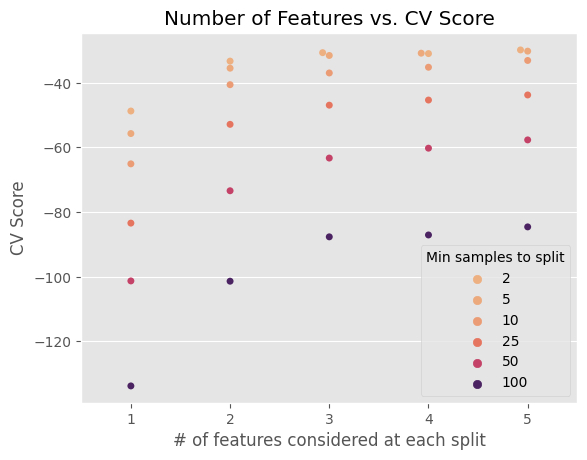

In [19]:
sns.swarmplot(data=forest_20_trees, x='param_max_features', y='mean_test_score', hue='param_min_samples_split', palette='flare')
plt.ylabel('CV Score')
plt.xlabel('# of features considered at each split')
plt.title('Number of Features vs. CV Score')
plt.legend(title='Min samples to split')
plt.show()

As the number of features at each split increases, the CV score increases as well but levels off at 3 features. The addition of more features will increase the training scores, but may not perform well on test data due to overfitting. Using all 8 features results in a bagged ensemble of trees rather than a random forest. The final random forest will consider 3 features at each split.

In [20]:
forest_20_trees_3_feat = forest_20_trees[forest_20_trees['param_max_features'] == 3]
forest_20_trees_3_feat.head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
135,0.109308,0.009154,0.007181,0.004388,3,2,20,"{'max_features': 3, 'min_samples_split': 2, 'n...",-29.519300,-33.890058,-38.101015,-20.854559,-30.974117,-30.667810,5.715736,41
146,0.098138,0.006327,0.004987,0.000631,3,5,20,"{'max_features': 3, 'min_samples_split': 5, 'n...",-31.388438,-32.928041,-38.385516,-25.023418,-29.988580,-31.542799,4.328589,49
157,0.088762,0.007410,0.005785,0.001163,3,10,20,"{'max_features': 3, 'min_samples_split': 10, '...",-40.886515,-34.004077,-44.570035,-28.286308,-36.998328,-36.949053,5.608947,99
168,0.079787,0.009628,0.004188,0.000399,3,25,20,"{'max_features': 3, 'min_samples_split': 25, '...",-47.335179,-45.904058,-58.009796,-38.892663,-44.417473,-46.911834,6.243213,143
179,0.071209,0.002999,0.005186,0.000399,3,50,20,"{'max_features': 3, 'min_samples_split': 50, '...",-69.769110,-57.502253,-76.894134,-51.378164,-60.797839,-63.268300,9.040461,206
190,0.063234,0.001347,0.004983,0.000007,3,100,20,"{'max_features': 3, 'min_samples_split': 100, ...",-97.397533,-87.415835,-98.886299,-72.213377,-82.266223,-87.635853,9.885313,266


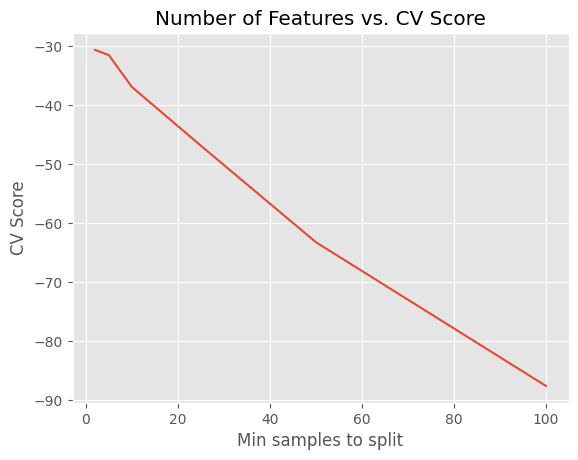

In [21]:
sns.lineplot(data=forest_20_trees_3_feat, x='param_min_samples_split', y='mean_test_score')
plt.ylabel('CV Score')
plt.xlabel('Min samples to split')
plt.title('Number of Features vs. CV Score')
plt.show()

It is clear that limiting the nodes that can split does not improve model performance.  The trees in the random forest should not have constricted depths.  This will not lead to overfitting since each tree is uncorrelated and the final prediction is an average of these uncorrelated trees. 

In [22]:
forest_20_trees_3_feat.iloc[0]

mean_fit_time                                                       0.109308
std_fit_time                                                        0.009154
mean_score_time                                                     0.007181
std_score_time                                                      0.004388
param_max_features                                                         3
param_min_samples_split                                                    2
param_n_estimators                                                        20
params                     {'max_features': 3, 'min_samples_split': 2, 'n...
split0_test_score                                                   -29.5193
split1_test_score                                                 -33.890058
split2_test_score                                                 -38.101015
split3_test_score                                                 -20.854559
split4_test_score                                                 -30.974117

The selected random forest has a CV score (mean_test_score) that is within one standard deviation of the model with the best score (-27.93 +/- 4.61).

In [23]:
final_random_forest = RandomForestRegressor(random_state=0, n_estimators=20, min_samples_split=2, max_features=3)
final_random_forest.fit(X_train, y_train)
y_hat_forest = final_random_forest.predict(X_test)
mse_forest = mean_squared_error(y_test, y_hat_forest)

print(f'Random Forest Train CV Score (MSE): {-1*forest_20_trees_3_feat.iloc[0]["mean_test_score"]:.3f}')
print(f'Random Forest Test MSE: {mse_forest:.3f}')

Random Forest Train CV Score (MSE): 30.668
Random Forest Test MSE: 29.121


## Gradient Boosted Trees

### Baseline GBM

In [24]:
gbm_baseline = GradientBoostingRegressor(random_state=0)
cv_score_gbm_baseline = cross_val_score(gbm_baseline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
gbm_baseline.fit(X_train, y_train)
gbm_baseline_mse = mean_squared_error(y_test, gbm_baseline.predict(X_test))

print(f'GBM Baseline CV Score: {cv_score_gbm_baseline}')
print(f'GBM Baseline Test MSE: {gbm_baseline_mse}')

GBM Baseline CV Score: -28.819010662003706
GBM Baseline Test MSE: 31.594039132243374


In [25]:
gbm_baseline.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [26]:
print('Baseline Feature Importances:\n')
for i,j in zip(gbm_baseline.feature_names_in_, gbm_baseline.feature_importances_):
    print(i, ': ', j)

Baseline Feature Importances:

cement :  0.2969461730299006
slag :  0.08047765964304146
flyash :  0.012741698717613522
water :  0.1023599378809138
superplasticizer :  0.07920050424254459
coarseaggregate :  0.01300243922707103
fineaggregate :  0.039882022257710155
age :  0.37538956500120485


### HyperParameter Tuning

In [27]:
gbm = GradientBoostingRegressor(random_state=0)

gbm_params = {'n_estimators': range(40, 1001, 20)}

grid_cv_gbm = GridSearchCV(gbm, param_grid=gbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv_gbm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1, param_grid={'n_estimators': range(40, 1501, 20)},
             scoring='neg_mean_squared_error')

In [28]:
grid_cv_results_gbm=pd.DataFrame(grid_cv_gbm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_gbm.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
42,2.039147,0.050040,0.005386,4.879178e-04,880,{'n_estimators': 880},-22.671279,-30.206196,-24.584743,-16.390187,-19.787987,-22.728078,4.651573,1
73,2.927778,0.134883,0.005393,4.843170e-04,1500,{'n_estimators': 1500},-22.836850,-29.976421,-24.614318,-16.598715,-19.625824,-22.730425,4.545355,2
68,3.837939,0.421327,0.016355,1.245185e-02,1400,{'n_estimators': 1400},-22.823549,-29.933437,-24.640682,-16.505134,-19.751843,-22.730929,4.542408,3
59,2.888476,0.110740,0.006981,5.519789e-07,1220,{'n_estimators': 1220},-22.839818,-30.069497,-24.624706,-16.402224,-19.720777,-22.731404,4.616630,4
44,2.113548,0.030246,0.005785,3.993035e-04,920,{'n_estimators': 920},-22.695920,-30.275523,-24.531841,-16.386124,-19.780011,-22.733884,4.671827,5


In [ ]:
test_mse = []
for i in range(40, 1001, 20):
    model = GradientBoostingRegressor(random_state=0, n_estimators=i)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    test_mse.append

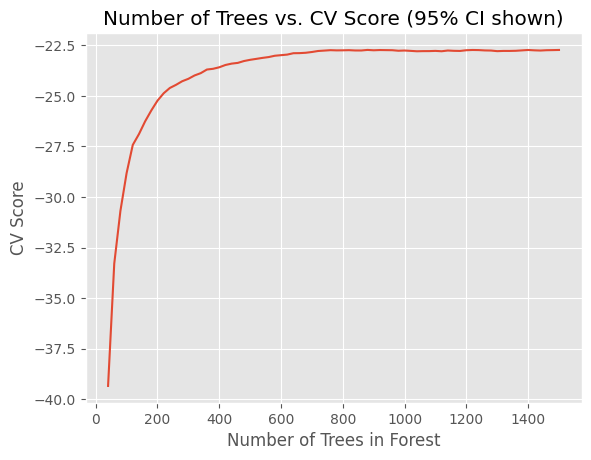

In [30]:
sns.lineplot(data=grid_cv_results_gbm, x='param_n_estimators', y='mean_test_score')
plt.ylabel('CV Score')
plt.xlabel('Number of Trees in Forest')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()